## For EC-Earth3_r8i1p1f1, look for RILE events for all months of the year and make RILE plots for the paper
#### Written By A. Jahn, June/July 2024

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.ndimage.filters import uniform_filter1d


/glade/derecho/scratch/ajahn/tmp/ipykernel_30891/3478677091.py:6: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


In [2]:
#Load data
data_path = '/glade/work/ajahn/CMIP6_daily_sic_data/'

#CanESM5	r8i1p1f1 goes ice-free in 4yr, 2028 to 2032 ssp126
hist_Can= xr.open_dataset(data_path+'/SIE_SIA_daily_CMIP6_Hist/SIA_SIE_hist_CanESM5_r9i1p1f1.nc')#fast

file_Can = xr.open_dataset(data_path+'ssp_SIA_SIE_data/SIA_SIE_ssp126_CanESM5_r9i1p1f1.nc')#fast

#Make ssp time dimension so xarray can use it and then remove leap day, if needed
dates_Can = xr.cftime_range(start='2015-01-01', periods=len(file_Can['time']), 
                           freq='D', calendar='noleap'
                           )     
file_Can['time'] = dates_Can

#Change format of time in ssp so can plot hist and ssp together
file_Can["time"] = file_Can["time"].astype("datetime64[ns]")

hist_Can["time"] = hist_Can["time"].astype("datetime64[ns]")

#Combine the two datasets
#Combine the two datasets
SIE=xr.concat((hist_Can['Arctic_SIE'],file_Can['Arctic_SIE']/1e12),dim='time')
SIA=xr.concat((hist_Can['Arctic_SIA'],file_Can['Arctic_SIA']/1e12),dim='time')


## CALCULATE when RILE threshold conditions are reached


**Auclair and Tremblay 2018:** "A rapid sea ice decline is defined as a period of at least 4 years for which the trend in the 5-year running mean minimum SIE is lower than −0.3 million km2 /year. We use the 5-year running mean to filter out the interannual variability and to identify tendencies in the sea ice cover on time scales of a few years to a decade." Note that this definition is slightly different than the one used by Holland et al. (2006). It emphasizes the total SIE loss in a given rapid decline event instead of the maximum rate of sea ice loss during the event.


In [3]:
#Convert monthly data array with one time dimension in datetime64 to array with year and month columns
def to_year_month(ds):
    year = ds.time.dt.year
    month = ds.time.dt.month

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), month=("time", month.data))

    # reshape the array to (..., "month", "year")
    return ds.set_index(time=("year", "month")).unstack("time")  


#Convert daily data array with one time dimension in datetime64 to array of year and julien day of the year in two columns
def to_year_dayofyear(ds):
    year = ds.time.dt.year
    dayofyear = ds.time.dt.dayofyear
    
    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), dayofyear=("time",dayofyear.data))

    # reshape the array to (..., "daofyear", "year")
    return ds.set_index(time=("year", "dayofyear")).unstack("time") 

#Convert daily data array with one time dimension in datetime64 to array of year, month, and day of the month
def to_year_month_day(ds):
    year = ds.time.dt.year
    month = ds.time.dt.month
    day = ds.time.dt.day
    
    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), month=("time", month.data),day=("time",day.data))

    # reshape the array to (..., "day","month", "year")
    return ds.set_index(time=("year", "month","day")).unstack("time")  

In [4]:
SIE_y_m_d=to_year_month_day(SIE)
SIA_y_m_d=to_year_month_day(SIA)

SIA_y_d=to_year_dayofyear(SIA)
SIA_min=SIA_y_d.min(dim='dayofyear')
SIE_y_m=SIE_y_m_d.mean(axis=2)
SIA_y_m=SIA_y_m_d.mean(axis=2)

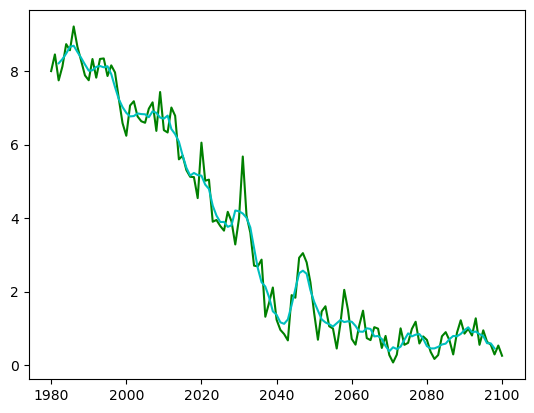

In [5]:
#Make 5yr running means 

year=np.arange(1980,2101,1); #create years
month=np.arange(1,13,1)
#Create new xr.Dataset with one variable (NHextent_model_5yrmean) and dims month, year and filled with zeros
SIE_5yr=xr.Dataset({'NHextent_model_5yrmean': (('month','year'),np.zeros(12*121).reshape(12,121))}, coords={'month': month, 'year': year})
SIE_5yr=SIE_5yr['NHextent_model_5yrmean'] #Grab one variable --> now its a xr.DataArray

for j in range(1,13):
    dummy=SIE_y_m.sel(month=j).rolling(year=5,center='True').mean()
    SIE_5yr[j-1,:]=dummy

plt.plot(SIE_y_m['year'].values,SIE_y_m.sel(month=9),'g')
plt.plot(SIE_5yr['year'].values,SIE_5yr.sel(month=9),'c')





### Find RILES as in Tremblay, make as RILE=1 if a RILE, RILE=0 if not a RILE 


In [6]:
#**** Find RILES as in Tremblay, make as RILE=1 if a RILE, RILE=0 if not a RILE    ***
RILE = SIE_5yr*0
RILE.name='Binary_RILE_indicator' #Change the name of the dataarray variable 

threshold=-0.3

total = 0
for yr1 in range(0,121):
    for yr2 in range(yr1+3,121):
        
        trend  = (SIE_5yr[:,yr2] - SIE_5yr[:,yr1]) / (yr2-yr1)
        rmask  = xr.where(trend <= threshold, 1,0)
        nriles = rmask.sum().values
        total +=nriles
        print(f"yr1={yr1} yr2={yr2} n_rile={nriles} total={total}  ",end="\r")

        if(nriles>0):
            for rile_yr in range(yr1, yr2):
                RILE[:,rile_yr] = xr.where(rmask>0,1,RILE[:,rile_yr])

In [7]:
#**** Find near RILES as in Tremblay, with slightly relaxed criteria , make as RILE=1 if a RILE, RILE=0 if not a RILE    ***
RILE2 = SIE_5yr*0
RILE2.name='Binary_RILE_indicator' #Change the name of the dataarray variable 

threshold=-0.299

total = 0
for yr1 in range(0,121):
    for yr2 in range(yr1+3,121):
        
        trend  = (SIE_5yr[:,yr2] - SIE_5yr[:,yr1]) / (yr2-yr1)
        rmask  = xr.where(trend <= threshold, 1,0)
        nriles = rmask.sum().values
        total +=nriles
        print(f"yr1={yr1} yr2={yr2} n_rile={nriles} total={total}  ",end="\r")

        if(nriles>0):
            for rile_yr in range(yr1, yr2):
                RILE2[:,rile_yr] = xr.where(rmask>0,1,RILE2[:,rile_yr])

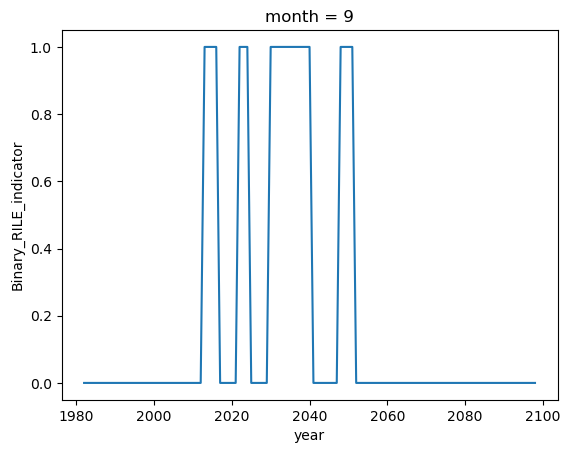

In [8]:
RILE[8,:].plot()

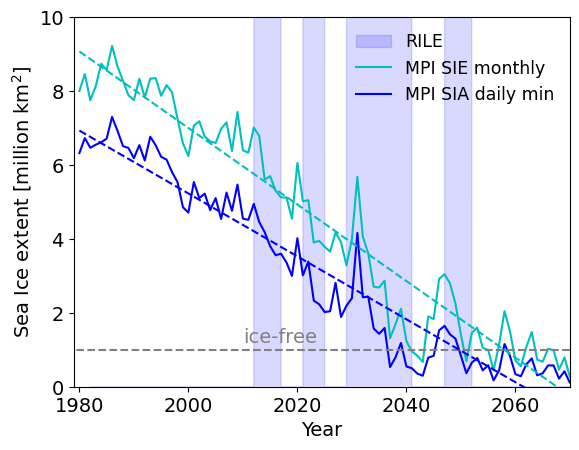

In [9]:
import scipy.stats as stats

#Make RILE plot for model time
R=RILE*1000

plt.fill(RILE['year'],R.sel(month=9),color='blue',alpha=0.15,label='RILE')

plt.plot(SIE_y_m['year'].values,SIE_y_m.sel(month=9),'c',label='MPI SIE monthly')
plt.plot(SIA_min['year'].values,SIA_min,'b',label='MPI SIA daily min')

#plt.axvspan(2026,2032, alpha=0.5, color='grey')

icefree=np.ones(100)
icefreeyr=np.linspace(1920,2100,100)
plt.plot(icefreeyr,icefree,'--',color='grey')
plt.xlabel('Year', fontsize=14);
plt.ylabel('Sea Ice extent [million km$^2$]', fontsize=14);
plt.ylim(0,10)
plt.xlim(1979,2070)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(loc='upper right', frameon=False, fontsize=14)
plt.legend(loc='best', frameon=False, fontsize=12.5)

plt.text(2010, 1.2, 'ice-free', fontsize=14, color='grey')
#plt.text(2025, 9, 'RILE', color='blue', fontsize=14)
xx=SIE_y_m['year'].sel(year=slice('1979','2070')).values
yy=SIE_y_m.sel(year=slice('1979','2070')).sel(month=9)
res= stats.linregress(xx,yy)
plt.plot(xx, res.intercept + res.slope*xx, 'c--', label='fitted line')
#print(res.intercept+(res.slope*xx).mean())

#plt.text(2025, 9, 'RILE', color='blue', fontsize=14)
xx=SIA_min['year'].sel(year=slice('1979','2070')).values
yy=SIA_min.sel(year=slice('1979','2070'))
res= stats.linregress(xx,yy)
plt.plot(xx, res.intercept + res.slope*xx, 'b--', label='fitted line')
#print(res.intercept+(res.slope*xx).mean())


plt.savefig("CanESM5_r9i1p1f1_ssp126_RILE.pdf")

In [10]:
print(2031-1980)
print(2031-2100)
#2023 equaivalent year = 2031
time_rel=np.arange(-51,70)


51
-69


In [11]:
#Load Obs data 
data_path2 = '/glade/u/home/ajahn/CMIP6_daily_SIE_SIA/'

daily_CDR = xr.open_dataset(data_path2+'NSIDC_CDR_daily_v4_SIA_SIE_197901-202312_no_leap.nc')
daily_SIE=daily_CDR['CDR_SIE']
daily_SIA=daily_CDR['CDR_SIA']
daily_time=daily_CDR['time']
#There is some daily data missing, so need to set those to nan so it isn't detected as the minimum
daily_SIA[ daily_SIA==0 ] = np.nan


obs_SIA_y_m_d=to_year_month_day(daily_SIA)
obs_SIA_y_m=obs_SIA_y_m_d.mean(axis=2)


obs_SIA_y_d=to_year_dayofyear(daily_SIA)
obs_SIA_min=obs_SIA_y_d.min(dim='dayofyear')

time_obs_rel=np.arange(-45,1)


<Figure size 640x480 with 0 Axes>

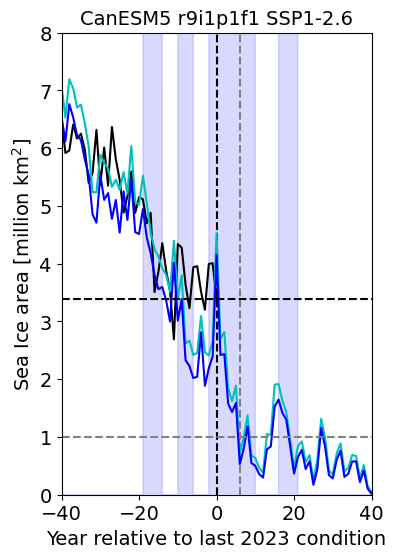

In [12]:
import scipy.stats as stats
plt.figure(constrained_layout=True)

plt.figure(figsize=(4,6))

R=RILE*1000

plt.fill(time_rel,R.sel(month=9),color='blue',alpha=0.15,label='RILE')
plt.vlines(0, 0,10, color='black', linestyle = '--')
plt.vlines(6, 0,10, color='grey', linestyle = '--')

plt.plot(time_obs_rel,obs_SIA_min,'k',label='CDR daily min SIA')

plt.plot(time_rel,SIA_y_m.sel(month=9),'c',label='Sept monthly SIA')
plt.plot(time_rel,SIA_min,'b',label='Daily min SIA')

#plt.axvspan(2026,2032, alpha=0.5, color='grey')

icefree=np.ones(100)
icefreeyr=np.linspace(1920,2100,100)
plt.plot(icefreeyr,icefree,'--',color='grey')
plt.xlabel('Year relative to last 2023 condition', fontsize=14);
plt.ylabel('Sea Ice area [million km$^2$]', fontsize=14);
plt.ylim(0,8)
plt.xlim(-40,40)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(loc='upper right', frameon=False, fontsize=14)
#plt.legend(loc='best', frameon=False, fontsize=9)
plt.axhline(y = 3.39, color = 'black', linestyle = '--')#,label='2023 daily min SIA') 
plt.axhline(y = 1., color = 'grey', linestyle = '--')#,label='2023 daily min SIA') 
#plt.text(-40, 1.1, 'ice-free', fontsize=12, color='grey')
#plt.text(-40, 3.5, '2023', fontsize=12, color='black')
plt.title('CanESM5 r9i1p1f1 SSP1-2.6',fontsize=14)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.savefig("CanESM5_r9i1p1f1_ssp126_RILE_relative_to_2023.pdf")


<Figure size 640x480 with 0 Axes>

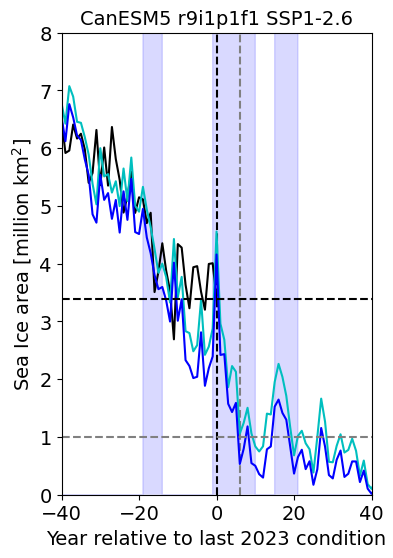

In [13]:
import scipy.stats as stats
plt.figure(constrained_layout=True)

plt.figure(figsize=(4,6))

R=RILE*1000

plt.fill(time_rel,R.sel(month=8),color='blue',alpha=0.15,label='RILE')
plt.vlines(0, 0,10, color='black', linestyle = '--')
plt.vlines(6, 0,10, color='grey', linestyle = '--')

plt.plot(time_obs_rel,obs_SIA_min,'k',label='CDR daily min SIA')

plt.plot(time_rel,SIA_y_m.sel(month=8),'c',label='Sept monthly SIA')
plt.plot(time_rel,SIA_min,'b',label='Daily min SIA')

#plt.axvspan(2026,2032, alpha=0.5, color='grey')

icefree=np.ones(100)
icefreeyr=np.linspace(1920,2100,100)
plt.plot(icefreeyr,icefree,'--',color='grey')
plt.xlabel('Year relative to last 2023 condition', fontsize=14);
plt.ylabel('Sea Ice area [million km$^2$]', fontsize=14);
plt.ylim(0,8)
plt.xlim(-40,40)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(loc='upper right', frameon=False, fontsize=14)
#plt.legend(loc='best', frameon=False, fontsize=9)
plt.axhline(y = 3.39, color = 'black', linestyle = '--')#,label='2023 daily min SIA') 
plt.axhline(y = 1., color = 'grey', linestyle = '--')#,label='2023 daily min SIA') 
#plt.text(-40, 1.1, 'ice-free', fontsize=12, color='grey')
#plt.text(-40, 3.5, '2023', fontsize=12, color='black')
plt.title('CanESM5 r9i1p1f1 SSP1-2.6',fontsize=14)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.savefig("CanESM5_r9i1p1f1_ssp126_RILE_relative_to_2023_Aug.pdf")


<Figure size 640x480 with 0 Axes>

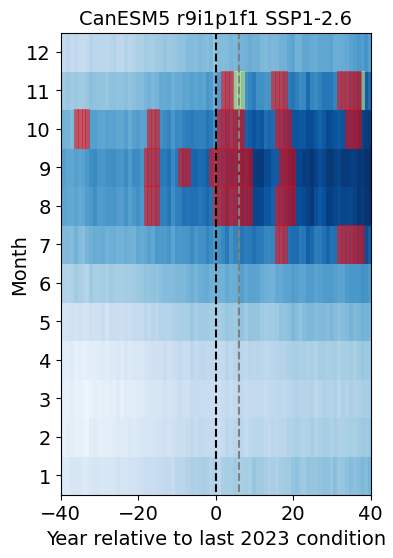

In [14]:
plt.figure(constrained_layout=True)

plt.figure(figsize=(4,6))
months=np.arange(1,13)
RILE = RILE.where(RILE > 0)
RILE2 = xr.where(RILE > 0,0,RILE2)
RILE2 = RILE2.where(RILE2 > 0)

plt.pcolor(time_rel, months,SIE_y_m.transpose(),cmap='Blues_r',vmin=0, vmax=18)
#cbar = plt.colorbar()
#cbar.set_label('Monthly mean SIA [million km$^2$]', fontsize=14)#rotation=270,labelpad=14
plt.pcolor(time_rel,months,RILE2,alpha=0.5,cmap='Wistia')#color='k')

plt.pcolor(time_rel,months,RILE,alpha=0.5,cmap='autumn')#color='k')
plt.vlines(0, 0,13, color='black', linestyle = '--')
plt.vlines(6, 0,13, color='grey', linestyle = '--')

#plt.axhline(y = 3.39, color = 'black', linestyle = '--')#,label='2023 daily min SIA') 
#plt.axhline(y = 1., color = 'grey', linestyle = '--')#,label='2023 daily min SIA') 
plt.title('CanESM5 r9i1p1f1 SSP1-2.6',fontsize=14)

plt.ylim(0.5,12.5)
plt.xlim(-40,40)
plt.xlabel('Year relative to last 2023 condition', fontsize=14);
plt.ylabel('Month', fontsize=14,labelpad=-2);
#cbar.ax.tick_params(labelsize=14)
plt.yticks(months,fontsize=14)
plt.xticks(fontsize=14)
plt.savefig("CanESM5_r9i1p1f1_ssp126_RILE_all_seasons.pdf")


In [18]:
print(RILE.isel(month=8).sel(year=2030)) #Sept RILE starts in 2030, one years before 2023 equivalent year in 2031
print(RILE.isel(month=7).sel(year=2031)) #Sept RILE starts in 2015, same year as 2023 equivalent year in 2031

<xarray.DataArray 'Binary_RILE_indicator' ()>
array(1.)
Coordinates:
    month    int64 9
    year     int64 2030
<xarray.DataArray 'Binary_RILE_indicator' ()>
array(1.)
Coordinates:
    month    int64 8
    year     int64 2031
